In [1]:
from pypropagate import *
import matplotlib.pyplot as plt
import warnings

%matplotlib inline

## Define the Waveguide

In [2]:
settings = presets.create_paraxial_wave_equation_settings()

presets.set_plane_wave_initial_conditions(settings)
s = settings.symbols

wg = settings.create_category('waveguide')
wg.create_symbol('n_1')
wg.create_symbol('n_2')
wg.create_symbol('r')
wg.create_symbol('l')

s.n = pc.piecewise((wg.n_1,s.x**2+s.y**2<=wg.r**2),(wg.n_2,True))

In [3]:
wg.n_1 = 1
wg.n_2 = presets.create_material('Ge',settings)
wg.r = 24*units.nm
wg.l = 0.6*units.mm

In [4]:
settings.wave_equation.set_energy(12*units.keV)

In [5]:
def compare_for_radius(radius,propagator_type,analytical_solution,difference=False):
    from pypropagate.plot import get_metric_prefix,get_unitless_bounds
    from pypropagate.coordinate_ndarray import CoordinateNDArray

    cmp_settings = settings.copy()
    cmp_settings.waveguide.r = radius
    
    propagator = propagator_type(cmp_settings)
    if propagator.ndim == 1:
        fd_field = propagator.run_slice(display_progress=False)[-2*wg.r:2*wg.r]
    else:
        fd_field = propagator.run_slice(display_progress=False)[-2*wg.r:2*wg.r,0]
    
    an_field = analytical_solution(cmp_settings)[-2*wg.r:2*wg.r].copy()
    
    split_data = np.append(fd_field[:0].data,an_field[0:].data,axis=0)
    split_field = CoordinateNDArray(split_data,an_field.bounds,an_field.axis,an_field.evaluate)
    
    xprefix = get_metric_prefix(get_unitless_bounds(split_field)[0][:2])[1] * units.m
    tz,tx = settings.get_as((s.zmax/(2*units.mm),1.5*radius/xprefix),float)

    plt.figure(figsize=(14,5))
    plt.title('$r = %s \mathrm{nm}$' % settings.get_numeric(radius/units.nm))
    plt.plot([0,settings.get_as(s.sz,float)],[0,0],'w--')
    text_settings={'color':'w','ha':'center','va':'center','size':16}
    plt.text(tz,tx,"Analytical",text_settings)
    plt.text(tz,-tx,propagator_type.__name__,text_settings)
    im = plot(split_field,ax=plt.gca())
    plt.colorbar(im)
    #plt.savefig('plots/waveguide_%s_%snm.pdf' % (propagator_type.__name__,settings.get_numeric(radius/units.nm)))
    
    if difference:
        plot(np.abs(fd_field - an_field),figsize=((14,5)))
        
    plt.show()

## Slab Waveguide

In [6]:
settings.simulation_box.set((50*wg.r,0,0.8*units.mm),(4000,0,2000))

In [7]:
def analytical_slab_waveguide(settings):
    from pypropagate.coordinate_ndarray import CoordinateNDArray

    import scipy.optimize
    import scipy.integrate
    from scipy.special import j0,j1,k0,k1
    import numpy as np
    from numpy import sqrt,ceil,pi,sign,cos,sin,exp,tan,sum,abs
    
    s = settings.symbols

    k = settings.get_as(s.k,float)
    n1 = settings.get_as(settings.waveguide.n_1,complex).conjugate()
    n2 = settings.get_as(settings.waveguide.n_2,complex).conjugate()
    d  = 2*settings.get_as(settings.waveguide.r,float)

    # We will determine um for all guided modes as the roots of the characteristic equation:
    def Char(kappa):
        gamma = sqrt((n1.real**2-n2.real**2)*k**2-kappa**2)
        #return tan(kappa*d) - (2*kappa*gamma/(kappa**2-gamma**2))
        return tan(kappa*d/2) - gamma/kappa
        
    kappa_max = sqrt(n1.real**2-n2.real**2)*k
        
    # maximum number of guided modes
    N = ceil(d*kappa_max/(2*pi))

    # Now find roots of the characteristic equation by searching intervals
    kappa_values = []
    segments = N
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
 
        while len(kappa_values) < N:
            segments = segments*2
            if segments>10000:
                break
            kappa_values = []
            xsegs = np.linspace(0,kappa_max,segments)
            for interval in [(xi,xj) for xi,xj in zip(xsegs[1:],xsegs[:-1])]:
                va,vb = Char(np.array(interval))
                # Check if values for interval boundaries are finite and have opposite sign
                if np.isfinite(va) and np.isfinite(vb) and sign(va) != sign(vb):
                    # There might be a root in the interval. Find it using Brent's method!
                    kappa,r = scipy.optimize.brentq(Char,interval[0],interval[1],full_output=True)
                    # Check that point converged and value is small (we might have converged to a pole instead)
                    if kappa!=0 and r.converged and abs(Char(kappa))<1:
                        kappa_values.append(kappa)
    
    kappa_values = np.array(kappa_values)

    # Define the guided modes
    def psi(kappa,r):
        gamma = sqrt((n1.real**2-n2.real**2)*k**2-kappa**2)
        return cos(kappa*r)*(r*2<=d) + cos(kappa*d/2) * exp(-gamma*(r-d/2)) * (r*2>d)
    
    # Normalize the modes by integrating the intensity of the guided modes over R
    B_values = [(2*scipy.integrate.quad(lambda r:abs(psi(kappa,r))**2,0,np.inf)[0])**(-0.5) for kappa in kappa_values]
        
    #Project the modes onto the plain wave initial condition
    c_values = [2*B**2*scipy.integrate.quad(lambda r:psi(kappa,r),0,np.inf)[0] for kappa,B in zip(kappa_values,B_values)]
    
    # Determine attenuation coeffcients
    mu_values = np.array([2*B**2*k*
            (scipy.integrate.quad(lambda r:abs(psi(kappa,r))**2*n1.imag,0,d/2)[0]   +
             scipy.integrate.quad(lambda r:abs(psi(kappa,r))**2*n2.imag,d/2,np.inf)[0])
                         for kappa,B in zip(kappa_values,B_values)])

    # The full solution is the superposition of the guided modes
    def field(x,r):
        solution = None
        for c,b,kappa,mu in zip(c_values,B_values,kappa_values,mu_values):
            beta = sqrt(k**2*n1.real**2 - kappa**2)
            mode = c * psi(kappa,r) * exp((-mu-1j*(beta-k))*x)
            if solution is None: solution = mode
            else: solution += mode
        return solution

    x_values = np.linspace(*settings.get_as((s.zmin,s.zmax,s.Nz),float))
    r_values = abs(np.linspace(*settings.get_as((s.xmin,s.xmax,s.Nx),float)))

    data = np.conjugate(field(*np.meshgrid(x_values,r_values)) )

    sx = settings.get_numeric(s.sx)
    sz = settings.get_numeric(s.sz)

    res = CoordinateNDArray(data,[(-sx/2,sx/2),(0,sz)],(s.x,s.z),settings.get_numeric_transform())
    return res

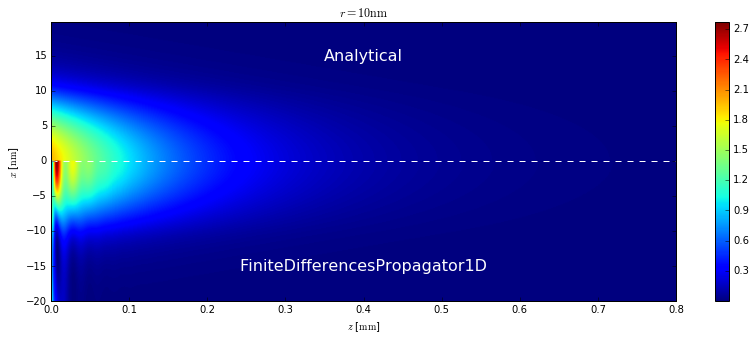

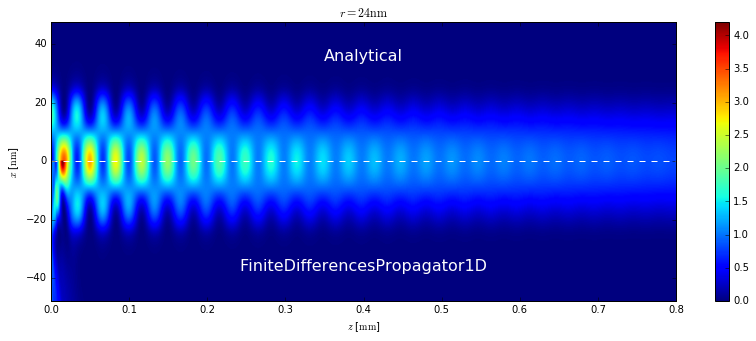

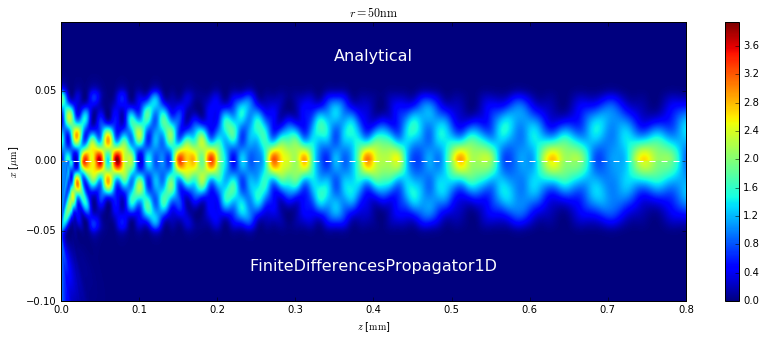

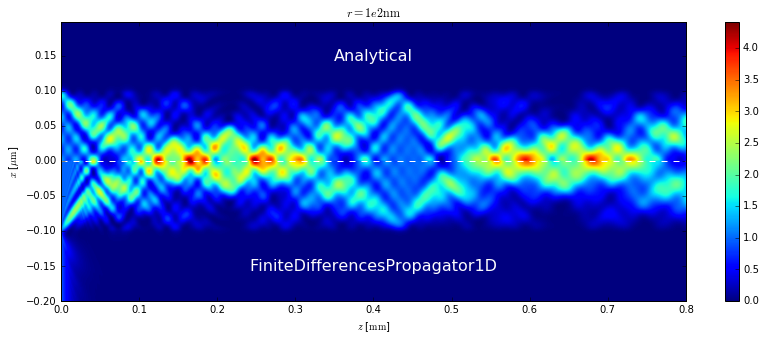

In [8]:
compare_for_radius(10*units.nm,propagators.FiniteDifferencesPropagator1D,analytical_slab_waveguide)
compare_for_radius(24*units.nm,propagators.FiniteDifferencesPropagator1D,analytical_slab_waveguide)
compare_for_radius(50*units.nm,propagators.FiniteDifferencesPropagator1D,analytical_slab_waveguide)
compare_for_radius(100*units.nm,propagators.FiniteDifferencesPropagator1D,analytical_slab_waveguide)

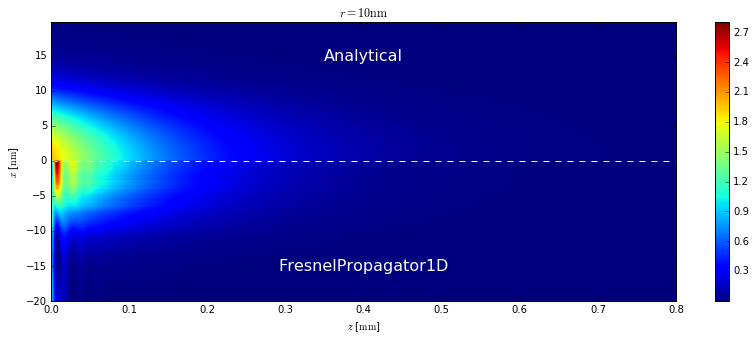

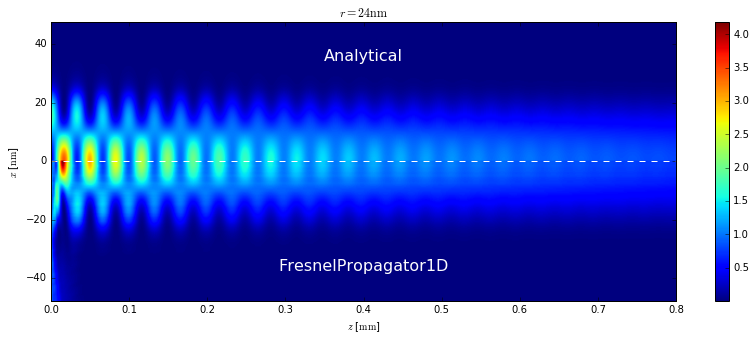

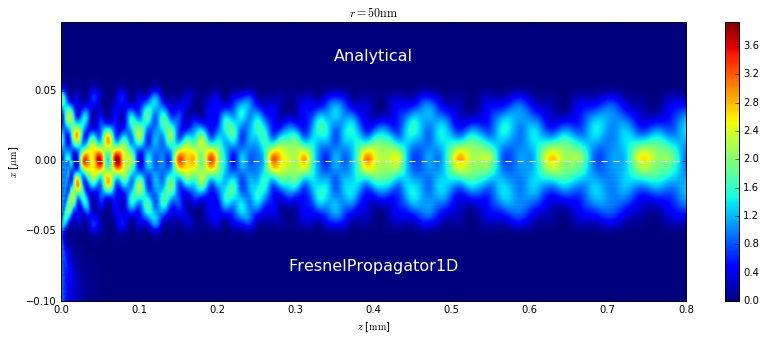

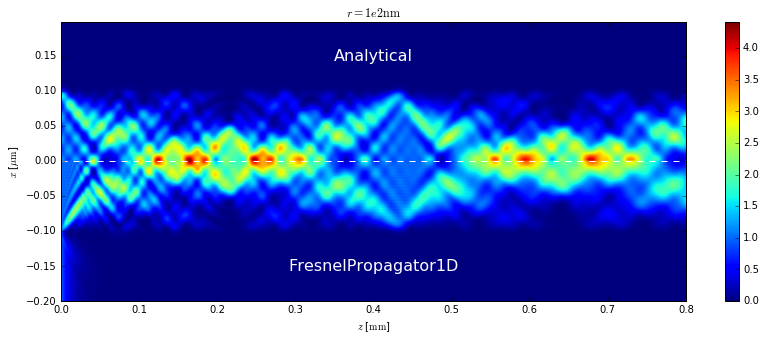

In [9]:
compare_for_radius(10*units.nm,propagators.FresnelPropagator1D,analytical_slab_waveguide)
compare_for_radius(24*units.nm,propagators.FresnelPropagator1D,analytical_slab_waveguide)
compare_for_radius(50*units.nm,propagators.FresnelPropagator1D,analytical_slab_waveguide)
compare_for_radius(100*units.nm,propagators.FresnelPropagator1D,analytical_slab_waveguide)

## Cylindrical Waveguide

In [8]:
settings.simulation_box.set((4*wg.r,4*wg.r,0.4*units.mm),(500,500,500))

In [9]:
def analytical_circular_waveguide(settings):
    
    from pypropagate.coordinate_ndarray import CoordinateNDArray
    
    import scipy.optimize
    import scipy.integrate
    from scipy.special import j0,j1,k0,k1
    import numpy as np
    from numpy import sqrt,ceil,pi,sign,cos,sin,exp,sum,abs
    
    s = settings.symbols
    
    kn = settings.get_as(s.k,float)
    n1 = settings.get_as(settings.waveguide.n_1,complex).conjugate()
    n2 = settings.get_as(settings.waveguide.n_2,complex).conjugate()
    a  = settings.get_as(settings.waveguide.r,float)
    
    # We will determine um for all guided modes as the roots of the characteristic equation:
    def char(um):
        wm = sqrt(V**2-um**2)
        return um*j1(um)/j0(um) - wm*k1(wm)/k0(wm)
    
    # Dimensionless waveguide paramter
    V = kn*a*sqrt(n1.real**2 - n2.real**2)
    
    # V determines the number of guided modes
    N = ceil(V/pi)
    
    # Now find all N roots of the characteristic equation
    u_values = []
    segments = N
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        while len(u_values) < N:
            segments = segments*2
            u_values = []
            xsegs = np.linspace(0,V,segments)
            for interval in [(xi,xj) for xi,xj in zip(xsegs[1:],xsegs[:-1])]:
                va,vb = char(np.array(interval))
                # Check if values for interval boundaries are finite and have opposite sign
                if np.isfinite(va) and np.isfinite(vb) and sign(va) != sign(vb):
                    # There might be a root in the interval. Find it using Brent's method!
                    um,r = scipy.optimize.brentq(char,interval[0],interval[1],full_output=True)
                    # Check that point converged and value is small (we might have converged to a pole instead)
                    if um!=0 and r.converged and abs(char(um))<1:
                        u_values.append(um)
    u_values = np.array(u_values)
    
    # Reactivate warnings
    warnings.resetwarnings()
    
    # Define the guided modes
    def psi(um,r):
        wm = sqrt(V**2-um**2)
        return np.piecewise(r,[r<a,r>=a],[lambda r:j0(um*r/a)/j0(um),lambda r:k0(wm*r/a)/k0(wm)])
   
    # Normalize the modes by integrating the intensity of the guided modes over R^2
    B_values = [(2*pi*scipy.integrate.quad(lambda r:abs(psi(um,r))**2*r,0,np.inf)[0])**(-0.5) for um in u_values]
    
    # Project the modes onto the plain wave initial condition
    c_values = [B**2*2*pi*scipy.integrate.quad(lambda r:psi(um,r)*r,0,np.inf)[0] for um,B in zip(u_values,B_values)]
    
    # Integrate mu in two parts to aviod discontinuity
    mu_values = np.array([
            2*pi*scipy.integrate.quad(lambda r:abs(psi(um,r)*B)**2*kn*n1.imag*r,0,a)[0] +
            2*pi*scipy.integrate.quad(lambda r:abs(psi(um,r)*B)**2*kn*n2.imag*r,a,np.inf)[0]
                         for um,B in zip(u_values,B_values)])
        
    beta_values = sqrt(n1.real**2*kn**2-u_values**2/a**2)
    
    # The full solution is the superposition of the guided modes
    def field(x,r):
        solution = None
        for i in range(len(u_values)):
            mode = c_values[i] * psi(u_values[i],np.abs(r)) * exp( (-1j*beta_values[i]-mu_values[i]) * x)
            if solution is None: solution = mode
            else: solution += mode
        return solution
    
    x_values = np.linspace(*settings.get_as((s.zmin,s.zmax,s.Nz),float))
    r_values = np.linspace(*settings.get_as((s.xmin,s.xmax,s.Nx),float))

    data = np.conjugate(field(*np.meshgrid(x_values,r_values)) * exp(1j*kn*x_values))
    
    sx = settings.get_numeric(s.sx)
    sz = settings.get_numeric(s.sz)
    
    res = CoordinateNDArray(data,[(-sx/2,sx/2),(0,sz)],(s.x,s.z),settings.get_numeric_transform())
    return res

In [10]:
compare_for_radius(10*units.nm,propagators.FiniteDifferencesPropagator2D,analytical_circular_waveguide)
compare_for_radius(24*units.nm,propagators.FiniteDifferencesPropagator2D,analytical_circular_waveguide)
compare_for_radius(50*units.nm,propagators.FiniteDifferencesPropagator2D,analytical_circular_waveguide)
compare_for_radius(100*units.nm,propagators.FiniteDifferencesPropagator2D,analytical_circular_waveguide)

KeyboardInterrupt: 

/usr/local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


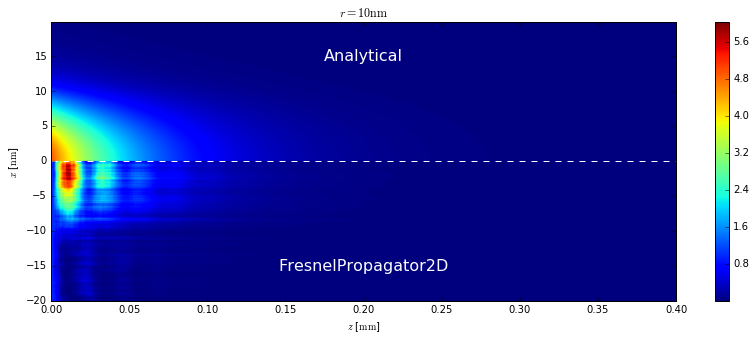

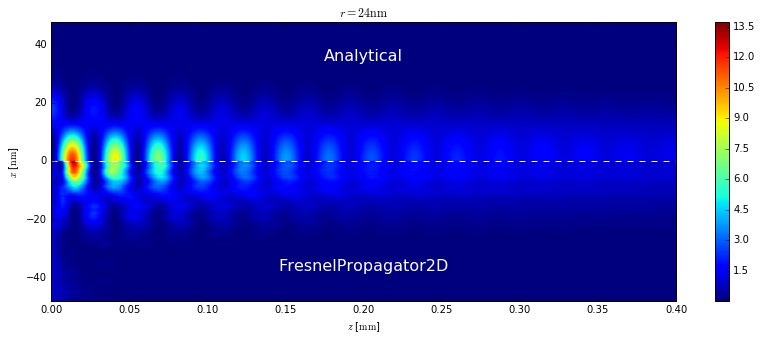

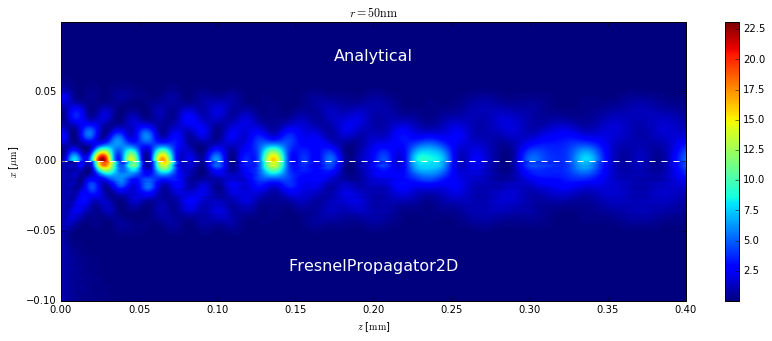

KeyboardInterrupt: 

In [11]:
compare_for_radius(10*units.nm,propagators.FresnelPropagator2D,analytical_circular_waveguide)
compare_for_radius(24*units.nm,propagators.FresnelPropagator2D,analytical_circular_waveguide)
compare_for_radius(50*units.nm,propagators.FresnelPropagator2D,analytical_circular_waveguide)
compare_for_radius(100*units.nm,propagators.FresnelPropagator2D,analytical_circular_waveguide)

## Plot from the paper

In [ ]:
settings.simulation_box.set((20*wg.r,20*wg.r,0.4*units.mm),(2000,2000,2000))

In [ ]:
from pypropagate.plot import get_metric_prefix,get_unitless_bounds
from pypropagate.coordinate_ndarray import CoordinateNDArray
import matplotlib.pyplot as plt

radius = 24*units.nm

cmp_settings = settings.copy()
cmp_settings.waveguide.r = radius

fd_field_2D = propagators.FiniteDifferencesPropagator1D(cmp_settings).run_slice()[-2*wg.r:2*wg.r]
fd_field_3D = propagators.FiniteDifferencesPropagator2D(cmp_settings).run_slice()[-2*wg.r:2*wg.r,0]

an_field_2D = analytical_slab_waveguide(cmp_settings)[-2*wg.r:2*wg.r].copy()
an_field_3D = analytical_circular_waveguide(cmp_settings)[-2*wg.r:2*wg.r].copy()

In [ ]:
split_data_2D = np.append(fd_field_2D[:0].data,an_field_2D[0:].data,axis=0)
split_field_2D = CoordinateNDArray(split_data_2D,an_field_2D.bounds,an_field_2D.axis,an_field_2D.evaluate)

split_data_3D = np.append(fd_field_3D[:0].data,an_field_3D[0:].data,axis=0)
split_field_3D = CoordinateNDArray(split_data_3D,an_field_3D.bounds,an_field_3D.axis,an_field_3D.evaluate)

xprefix = get_metric_prefix(get_unitless_bounds(split_field_2D)[0][:2])[1] * units.m
tz,tx = settings.get_as((s.zmax/(2*units.mm),1.5*radius/xprefix),float)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,2.5))

text_settings={'color':'w','ha':'left','va':'center','size':12}

ax1.plot([0,settings.get_as(s.sz,float)],[0,0],'w--')
ax1.text(0.05,tx,"Analytical",text_settings)
ax1.text(0.05,-tx,'Finite Differences',text_settings)
im = plot(split_field_2D,ax=ax1,interpolation='none')
ax1.xaxis.set_ticks([0.1*i for i in range(4)])

cbaxes = fig.add_axes([0.27, 0.9, 0.2, 0.05]) 
cbar = fig.colorbar(im,cax=cbaxes, orientation='horizontal')
cbaxes.tick_params(axis='x', colors='white')
for pos in ['top', 'bottom', 'right', 'left']:
    cbaxes.spines[pos].set_edgecolor('white')
cbar.outline.set_visible(False)
cbar.set_ticks([i for i in range(5)])

ax2.plot([0,settings.get_as(s.sz,float)],[0,0],'w--')
#ax2.text(0.05,tx,"Analytical",text_settings)
#ax2.text(0.05,-tx,'Finite Differences',text_settings)
im = plot(split_field_3D,ax=ax2,interpolation='none')
ax2.xaxis.set_ticks([0.1*i for i in range(0,5)])

cbaxes = fig.add_axes([0.75, 0.9, 0.2, 0.05]) 
cbar = fig.colorbar(im,cax=cbaxes, orientation='horizontal')
cbaxes.tick_params(axis='x', colors='white')
for pos in ['top', 'bottom', 'right', 'left']:
    cbaxes.spines[pos].set_edgecolor('white')
cbar.outline.set_visible(False)
cbar.set_ticks([4*i for i in range(12)])

ax2.axes.yaxis.label.set_alpha(0)
ax2.axes.yaxis.label.set_size(0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.tight_layout(pad=0)

plt.savefig('analytical_waveguide.pdf')

plt.show()